Step 0: Loading libraries and basic settings
----------------------------------------

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from nistats.design_matrix import make_design_matrix

from scipy import stats
from fctools import denoise, figures, stats

#---- matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 25
medium = 25
bigger = 25

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

Step 1: Data preparation
----------------------------------------

In [2]:
#--- setting main input directory
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/figures/'

#---selecting subjects who finished the study
groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/behavioral/group_assignment.csv')
trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
subs = trained_subs['sub'].values
print(f'Sample size: {len(subs)}')

#---setting sessions and task names
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
#tasks = ['rest']
tasks = ['dualnback']

#---loading events
events = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv')
condition = denoise.get_condition_column(events)
condition['no'] = np.arange(len(condition))
condition.head()

Sample size: 46


/home/finc/anaconda/lib/python3.6/site-packages/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


,condition,no
0,intro,0
1,intro,1
2,1-back,2
3,1-back,3
4,1-back,4


Step 2: Looping over subjects and merging their confound files
-----------------------------------------------------------------

In [12]:
confounds = pd.DataFrame()

for sub in subs:
    for ses in sess:
        for task in tasks:
            
            #--- getting directory/file names
            sub_dir = f'{top_dir}{sub}/{ses}/func/'
            sub_name = f'{sub}_{ses}_task-{task}' 
            
            #--- loading confound data
            confounds_path1 = f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv'
            confounds_path2 = f'{sub_dir}{sub_name}_bold_confounds.tsv'
            
            conf1 = pd.read_csv(confounds_path1)
            conf1 = pd.DataFrame(conf1, columns =['scrubbing'])
            conf1['sub'] = sub
            conf1['ses'] = ses
            conf1['task'] = task
            conf1['no'] = np.arange(len(conf1))
            
            conf2 = pd.read_csv(confounds_path2, delimiter = '\t')
            conf2 = pd.DataFrame(conf2, columns =['FramewiseDisplacement'])
            conf2.FramewiseDisplacement[0] = 0
            conf2['no'] = np.arange(len(conf2))
            
            conf_all = pd.merge(conf1, conf2, on = 'no')
            conf_all = pd.merge(conf_all, condition, on = 'no')
        confounds = pd.concat((confounds, conf_all))

confounds = pd.merge(confounds, trained_subs, on = 'sub')
confounds = confounds.rename(index=str, columns={"group": "Group", "ses": "Session", "condition": "Condition" })

confounds.to_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/neuroimaging/coundfounds_summary.csv', 
                 sep = ',', index = False)
confounds.head()

,scrubbing,sub,Session,task,no,FramewiseDisplacement,Condition,Group
0,0,sub-01,ses-1,dualnback,0,0.000000,intro,Control
1,0,sub-01,ses-1,dualnback,1,0.087902,intro,Control
2,0,sub-01,ses-1,dualnback,2,0.044173,1-back,Control
3,0,sub-01,ses-1,dualnback,3,0.071255,1-back,Control
4,0,sub-01,ses-1,dualnback,4,0.071543,1-back,Control


In [2]:
#--- read from .csv
confounds = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/neuroimaging/coundfounds_summary.csv')
confounds.head()

,scrubbing,sub,Session,task,no,FramewiseDisplacement,Condition,Group
0,0,sub-01,ses-1,dualnback,0,0.000000,intro,Control
1,0,sub-01,ses-1,dualnback,1,0.087902,intro,Control
2,0,sub-01,ses-1,dualnback,2,0.044173,1-back,Control
3,0,sub-01,ses-1,dualnback,3,0.071255,1-back,Control
4,0,sub-01,ses-1,dualnback,4,0.071543,1-back,Control


Step 3: Summarizing pandas dataframe
--------------------------------------

In [4]:
f = {'scrubbing':['sum'], 'FramewiseDisplacement':['mean']}

#--- total
outlier_all = confounds.groupby(['sub','Session','Group']).agg(f).reset_index()
outlier_all['OutlierPerc'] = (outlier_all.scrubbing['sum']/340)*100
outlier_all['FD'] = outlier_all.FramewiseDisplacement['mean']

#--- grouped by condition
outlier_cond = confounds.groupby(['sub','Session','Group', 'Condition']).agg(f).reset_index()
outlier_cond['OutlierPerc'] = (outlier_cond.scrubbing['sum']/150)*100
outlier_cond['FD'] = outlier_cond.FramewiseDisplacement['mean']

outlier_cond = outlier_cond[outlier_cond.Condition != 'intro']
outlier_all.head()

,sub,Session,Group,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,sum,mean,,
0,sub-01,ses-1,Control,7,0.102797,2.058824,0.102797
1,sub-01,ses-2,Control,5,0.116259,1.470588,0.116259
2,sub-01,ses-3,Control,18,0.159409,5.294118,0.159409
3,sub-01,ses-4,Control,0,0.086909,0.000000,0.086909
4,sub-02,ses-1,Control,0,0.057488,0.000000,0.057488


Step 4: Plotting
-----------------

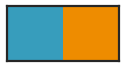

In [5]:
#--- setting colors for groups
col_groups = ['#379dbc','#ee8c00']
sns.set_palette(col_groups)
sns.palplot(sns.color_palette(col_groups))

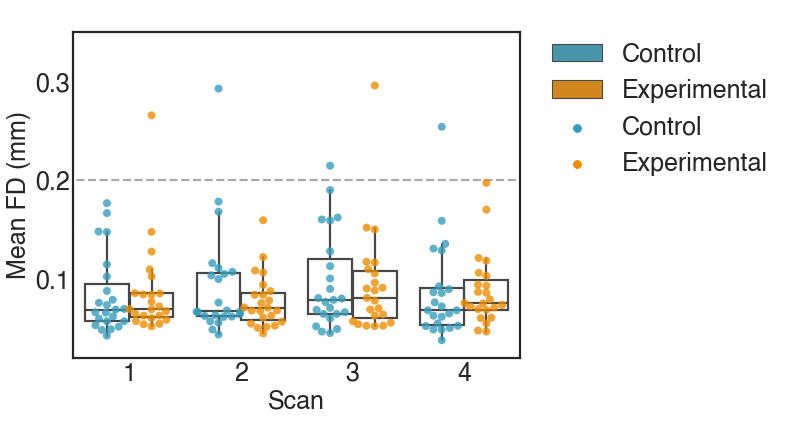

In [6]:
#--- plotting mean total framewise displacement (FD)
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Group', data = outlier_all)
ax.set(title=' ')
ax.set(ylabel='Mean FD (mm)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(0.02, 0.35)  

plt.savefig(f'{out_dir}fig_S1a.pdf', bbox_inches="tight", dpi=300)

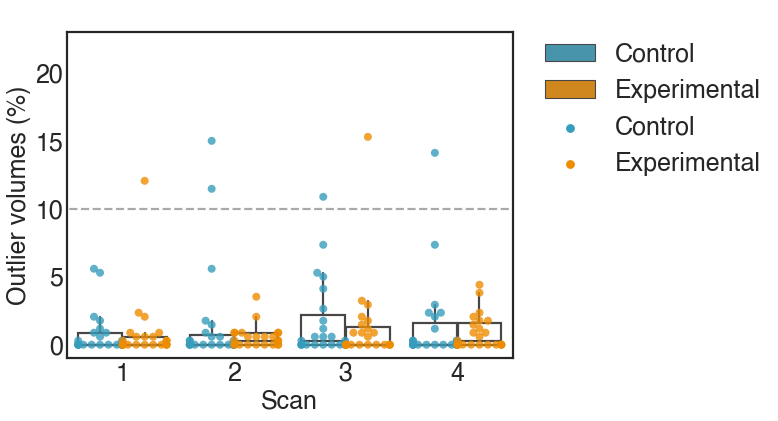

In [7]:
#--- plotting total percent of outlier scans
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Group', data = outlier_all)
ax.set(title=' ')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1b.pdf', bbox_inches="tight", dpi=300)

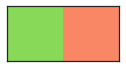

In [12]:
#--- setting colors for conditions

col_cond = ['#88d958','#f98766']
sns.set_palette(col_cond)
sns.palplot(sns.color_palette(col_cond))

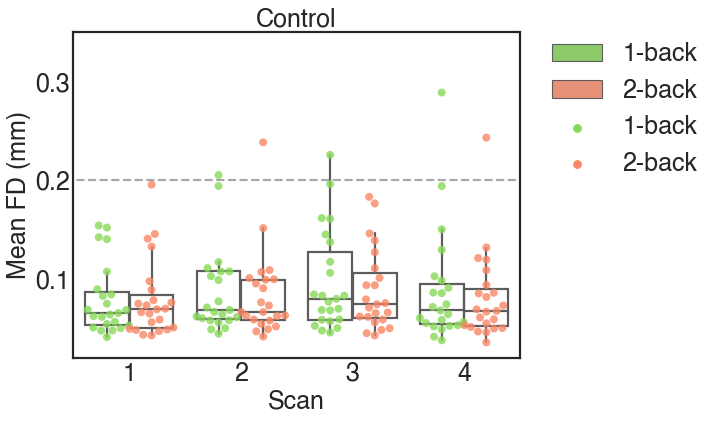

In [13]:
#--- plotting mean framewise displacement (FD) for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Control'])
ax.set(title='Control')
ax.set(ylabel='Mean FD (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.ylim(0.02, 0.35)  
plt.setp(ax.spines.values(), linewidth=2.2)
plt.savefig(f'{out_dir}fig_S1c.pdf', bbox_inches="tight", dpi=300)

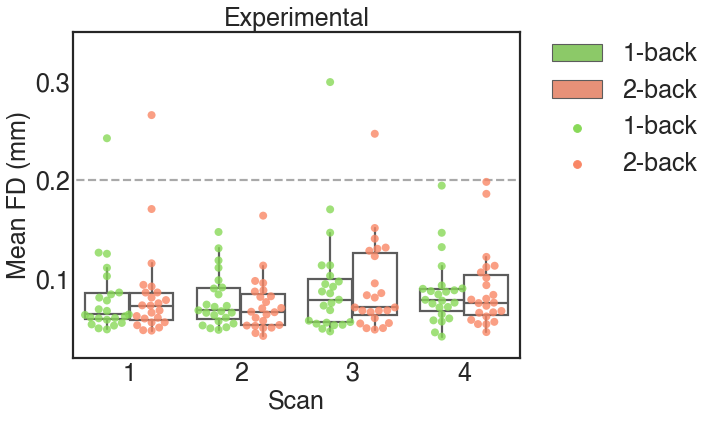

In [14]:
#--- plotting mean framewise displacement (FD) for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Experimental'])
ax.set(title='Experimental')
ax.set(ylabel='Mean FD (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(0.02, 0.35)  
plt.savefig(f'{out_dir}fig_S1d.pdf', bbox_inches="tight", dpi=300)

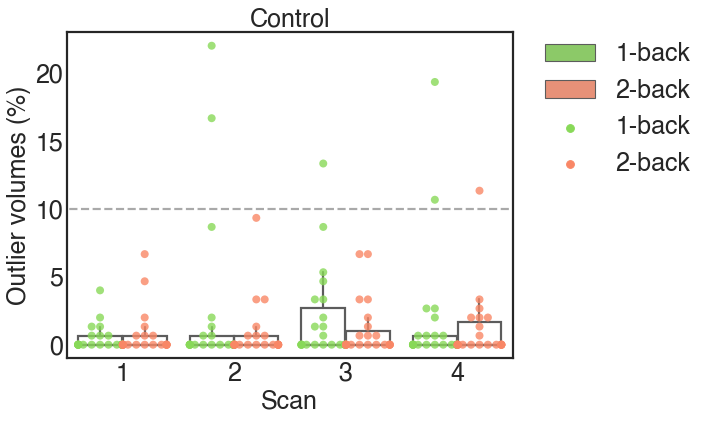

In [15]:
#--- plotting % outlier scans for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Control'])
ax.set(title='Control')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1e.pdf', bbox_inches="tight", dpi=300)


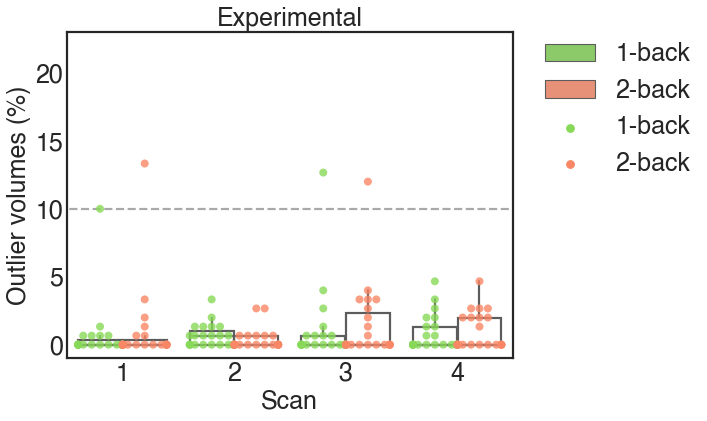

In [16]:
#--- plotting % outlier scans for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Experimental'])
ax.set(title='Experimental')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1f.pdf', bbox_inches="tight", dpi=300)


Step 5: Deciding which subjects to exclude
-----------------------

In [24]:
outlier_all.head()

,sub,Session,Group,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,sum,mean,,
0,sub-01,ses-1,Control,7,0.102797,2.058824,0.102797
1,sub-01,ses-2,Control,5,0.116259,1.470588,0.116259
2,sub-01,ses-3,Control,18,0.159409,5.294118,0.159409
3,sub-01,ses-4,Control,0,0.086909,0.000000,0.086909
4,sub-02,ses-1,Control,0,0.057488,0.000000,0.057488


In [25]:
criteria = (outlier_all.FD > 0.2) | (outlier_all.OutlierPerc > 10)
excluded = outlier_all[criteria]
ex = np.unique(excluded['sub'].values)

print(f'Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: {ex}')

excluded

Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: ['sub-13' 'sub-21' 'sub-23' 'sub-50']


,sub,Session,Group,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,sum,mean,,
41,sub-13,ses-2,Control,51,0.292881,15.000000,0.292881
42,sub-13,ses-3,Control,37,0.214841,10.882353,0.214841
43,sub-13,ses-4,Control,48,0.254199,14.117647,0.254199
68,sub-21,ses-1,Experimental,41,0.265856,12.058824,0.265856
74,sub-23,ses-3,Experimental,52,0.295999,15.294118,0.295999
157,sub-50,ses-2,Control,39,0.168320,11.470588,0.168320


In [27]:
criteria_cond = (outlier_cond.FD > 0.2) | (outlier_cond.OutlierPerc > 10)
excluded_cond = outlier_cond[criteria_cond]

ex_cond = np.unique(excluded_cond['sub'].values)

print(f'Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: {ex_cond}')

excluded_cond

Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: ['sub-13' 'sub-21' 'sub-23' 'sub-50']


,sub,Session,Group,Condition,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
123,sub-13,ses-2,Control,1-back,33,0.360719,22.000000,0.360719
124,sub-13,ses-2,Control,2-back,14,0.238502,9.333333,0.238502
126,sub-13,ses-3,Control,1-back,20,0.225853,13.333333,0.225853
129,sub-13,ses-4,Control,1-back,29,0.288901,19.333333,0.288901
130,sub-13,ses-4,Control,2-back,17,0.243322,11.333333,0.243322
204,sub-21,ses-1,Experimental,1-back,15,0.242636,10.000000,0.242636
205,sub-21,ses-1,Experimental,2-back,20,0.266076,13.333333,0.266076
222,sub-23,ses-3,Experimental,1-back,19,0.299484,12.666667,0.299484
223,sub-23,ses-3,Experimental,2-back,18,0.247164,12.000000,0.247164


In [5]:
to_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50']

Step 6: Calculate mean of FD and % of outlier scans
-----------------------

In [6]:
clean_cond = outlier_cond[~outlier_cond['sub'].isin(to_exclude)]
clean_all = outlier_all[~outlier_all['sub'].isin(to_exclude)]

In [30]:
clean_cond.groupby(['Group', 'Session','Condition']).mean()[['Group', 'FD', 'OutlierPerc']]

FD OutlierPerc
                                                    
Group        Session Condition                      
Control      ses-1   1-back     0.073047    0.222222
                     2-back     0.073446    0.444444
             ses-2   1-back     0.080608    0.634921
                     2-back     0.075341    0.317460
             ses-3   1-back     0.086675    1.047619
                     2-back     0.079724    0.571429
             ses-4   1-back     0.073583    0.476190
                     2-back     0.071452    0.507937
Experimental ses-1   1-back     0.074626    0.190476
                     2-back     0.076489    0.380952
             ses-2   1-back     0.078148    0.634921
                     2-back     0.073328    0.380952
             ses-3   1-back     0.082747    0.507937
                     2-back     0.086070    0.984127
             ses-4   1-back     0.086984    0.825397
                     2-back     0.089315    0.920635

In [31]:
clean_all.groupby(['Group', 'Session']).mean()[['Group', 'FD', 'OutlierPerc']]

FD OutlierPerc
                                          
Group        Session                      
Control      ses-1    0.078066    0.574230
             ses-2    0.080525    0.560224
             ses-3    0.086840    1.064426
             ses-4    0.075071    0.574230
Experimental ses-1    0.078692    0.420168
             ses-2    0.077540    0.588235
             ses-3    0.084885    0.756303
             ses-4    0.089339    0.938375

Step 7: Calculate test statistic to compare groups/sessions/conditions
-----------------------

In [5]:
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
conds = ['1-back', '2-back']
groups = ['Control', 'Experimental']

Comparing conditions
---------------------------------

In [10]:
#--- differences in FD between conditions for experimental group
stats.ttest_rel_cond('Experimental','FD', data = clean_cond)

,statistic,pval
0,-0.597848,0.556651
1,1.919393,0.069316
2,-0.808793,0.428151
3,-0.716073,0.482224


In [11]:
#--- differences in FD between conditions for control group
stats.ttest_rel_cond('Control','FD', data = clean_cond)

,statistic,pval
0,-0.164257,0.871177
1,1.839224,0.080777
2,2.687454,0.014161
3,0.508172,0.616892


In [12]:
#--- differences in % of oultier scans between conditions for experimental group
stats.ttest_rel_cond('Experimental','OutlierPerc', data = clean_cond)

,statistic,pval
0,-1.300054,0.208366
1,1.562929,0.133755
2,-1.825742,0.082859
3,-0.358825,0.723486


In [13]:
#--- differences in % of oultier scans between conditions for control group
stats.ttest_rel_cond('Control','OutlierPerc', data = clean_cond)

,statistic,pval
0,-1.233588,0.231658
1,1.156243,0.261207
2,2.151657,0.043823
3,-0.181369,0.857903


Comparing sessions 
---------------------------------

In [29]:
stats.ttest_rel_sess('Experimental','FD', data = clean_all)[:,:,0]

array([[        nan,  0.19845373, -1.0692409 , -1.17607465],
       [-0.19845373,         nan, -1.8061182 , -1.53000158],
       [ 1.0692409 ,  1.8061182 ,         nan, -0.53652127],
       [ 1.17607465,  1.53000158,  0.53652127,         nan]])

In [32]:
stats.ttest_rel_sess('Experimental','OutlierPerc', data = clean_all)[:,:,0]

array([[        nan, -0.77363024, -1.67910192, -1.49956192],
       [ 0.77363024,         nan, -0.66605024, -0.99499779],
       [ 1.67910192,  0.66605024,         nan, -0.50587104],
       [ 1.49956192,  0.99499779,  0.50587104,         nan]])

In [33]:
stats.ttest_rel_sess('Control','FD', data = clean_all)[:,:,0]

array([[        nan, -0.46024797, -1.07523965,  0.5486624 ],
       [ 0.46024797,         nan, -0.94951099,  1.46362197],
       [ 1.07523965,  0.94951099,         nan,  1.89452319],
       [-0.5486624 , -1.46362197, -1.89452319,         nan]])

In [31]:
stats.ttest_rel_sess('Control','OutlierPerc', data = clean_all)[:,:,0]

array([[            nan,  5.34828187e-02, -1.28489042e+00,
        -8.93449555e-17],
       [-5.34828187e-02,             nan, -1.58665766e+00,
        -6.71913141e-02],
       [ 1.28489042e+00,  1.58665766e+00,             nan,
         1.37546061e+00],
       [ 8.93449555e-17,  6.71913141e-02, -1.37546061e+00,
                    nan]])

Comparing groups 
---------------------------------

In [18]:
stats.ttest_ind_groups('FD', clean_all)

,statistic,pval
0,0.066540,0.947280
1,-0.324753,0.747061
2,-0.184843,0.854286
3,1.387678,0.172917


In [19]:
stats.ttest_ind_groups('OutlierPerc', clean_all)

,statistic,pval
0,-0.502655,0.617963
1,0.084478,0.933098
2,-0.707802,0.483172
3,1.027179,0.310508
